In [ ]:
from google.colab import drive
import zipfile
import os

MOUNT_DIR = '/content/drive'
DATA_DIR_SMALLER = '/content/drive/MyDrive/DatasetSmaller.zip'
EXTRACTED_DIR = '/content/dataFolder'

# Mount Google Drive
drive.mount(MOUNT_DIR, force_remount=False)

# Path to the zip file in your Google Drive
zip_file_path = DATA_DIR_SMALLER

# Directory to extract the contents
extracted_dir_path = EXTRACTED_DIR


def extract_data(extracted_dir_path):
  # Extract the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extracted_dir_path)

extract_data(extracted_dir_path)

Mounted at /content/drive


In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils import data

# To Read Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
# To Interpret results & obtain plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# You could add your own libraries from Python Standard Library in this cell. Any other external libraries are not allowed.
import os

In [ ]:
class ChestDataset(Dataset):
    def __init__(self, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.path_label_list = self.data.imgs


    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        # Load image and label from the dataset based on the index
        image_path, label = self.path_label_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None, None

        # print("Image size before transformation:", image.size)

        # Optionally apply transformations
        if self.transform:
            image = self.transform(image)

        # print("Image size after transformation:", image.shape)

        return image, label

def get_dataset(root):
    # Define transformations for the images
    transform = transforms.Compose([
        transforms.Resize((299, 299
                        )),
        transforms.ToTensor(),
    ])

    # Load datasets for training, validation, and test with size (224, 224)
    dataset = ChestDataset(path=root, transform=transform)

    # Compute mean and std for normalization
    def compute_mean_and_std(dataset):
        mean_sum = np.zeros(3)
        std_sum = np.zeros(3)
        num_samples = len(dataset)

        for img, _ in dataset:
            img = np.array(img)
            # Compute mean along height and width axes
            img_mean = np.mean(img, axis=(1, 2))
            # Compute std along height and width axes
            img_std = np.std(img, axis=(1, 2))

            mean_sum += img_mean
            std_sum += img_std

        # Compute overall mean and std across all images
        mean = mean_sum / num_samples
        std = std_sum / num_samples

        return mean, std

    train_mean, train_std = compute_mean_and_std(dataset)

    # Apply normalization with computed mean and std
    transform = transforms.Compose([
        transform,
        transforms.Normalize(mean=train_mean, std=train_std)
    ])

    # Apply normalization to datasets
    dataset.transform = transform

    return dataset

In [ ]:
class DenseNet121(nn.Module):
    """Classifier with DenseNet121 backbone.
    See https://arxiv.org/abs/1608.06993 for more details.
    """

    def __init__(self, n_classes: int) -> None:
        """Initialize the DenseNet121 model."""
        super(DenseNet121, self).__init__()
        self.densenet = densenet121(weights=DenseNet121_Weights) # Pretrained weights are set to False
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(self.densenet.classifier.in_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the DenseNet121 model."""
        x = self.densenet.features(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


In [ ]:
def get_loaders(data_foldername, train_batch = 64, test_batch = 64, val_batch = 64):
    # Create datasets
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dataset = get_dataset(dataset_path)

    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = data.random_split(dataset, [train_size, val_size, test_size])

    # Create dataset loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch)
    val_loader = DataLoader(dataset=val_dataset, batch_size=val_batch)

    return train_loader, test_loader, val_loader

def get_num_of_classes(data_foldername):
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dummy_dataset = ChestDataset(path=dataset_path)
    num_of_classes = len(dummy_dataset.data.classes)

    return num_of_classes

def train_for_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

def validate_for_epoch(model, val_loader, loss_fn, device):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return val_loss / len(val_loader), accuracy

def train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path):
    best_val_loss = float('inf')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(max_epoch):
        # Training
        train_loss, train_accuracy = train_for_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)  # Corrected variable name

        # Validation
        val_loss, val_accuracy = validate_for_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{max_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save best model according to validation performance
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)


    history = {'train_losses': train_losses, 'train_accuracies': train_accuracies, 'val_losses': val_losses, 'val_accuracies': val_accuracies}

    return history

def plot_losses(history):
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses vs Epoch')
    plt.legend()
    plt.show()

def plot_accuracies(history):
    plt.plot(history['train_accuracies'], label='Train Accuracy')
    plt.plot(history['val_accuracies'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

def load_best_model(model_path):
    state_dict = torch.load(model_path)
    # Instantiate your model
    model = CNN()
    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def load_best_model_transfer(model_path, data_foldername):
    state_dict = torch.load(model_path)

    # Instantiate your model
    model = DenseNet121(n_classes=NUM_CLASSES)

    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def test_model(model, test_loader, device):
    model.eval()
    loss_func = nn.CrossEntropyLoss()

    all_predictions = []
    all_targets = []
    all_losses = []
    all_probs = [] # for roc-auc

    # Move model to device
    model.to(device)

    # Disable gradients for evaluation
    with torch.no_grad():
        for images, targets in test_loader:
            # Move images and targets to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(images)
            # Compute loss
            loss = loss_func(outputs, targets)
            all_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Get probabilities
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(outputs)
            all_probs.extend(probs.cpu().numpy())

    # Convert targets and predictions to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    return all_losses, all_predictions, all_targets, all_probs

def calculate_metrics(all_losses, all_predictions, all_targets):
    # Calculate evaluation metrics
    mean_loss = np.mean(all_losses)
    acc = accuracy_score(all_targets, all_predictions)
    pre = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Return metric results as a dictionary
    metrics = {
        'mean_loss': mean_loss,
        'accuracy': acc,
        'precision': pre,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

def plot_confusion_matrix(conf_matrix, classes):
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_auc(targets, probs, class_names):
    num_classes = probs.shape[1]
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        # Create binary target for the current class
        binary_targets = np.array(targets == i, dtype=int)
        fpr, tpr, _ = roc_curve(binary_targets, probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve ({}) (AUC = {:.2f})'.format(class_names[i], roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Load datasets for training, validation, and test with size (224, 224)
dataset = ChestDataset(path="dataFolder/folder")

# Access the classes attribute to get the class names
class_names = dataset.data.classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s]


Epoch [1/40], Train Loss: 1.5751, Train Accuracy: 0.3137, Val Loss: 3.4501, Val Accuracy: 0.1700
Epoch [2/40], Train Loss: 1.4032, Train Accuracy: 0.4138, Val Loss: 1.8112, Val Accuracy: 0.2700
Epoch [3/40], Train Loss: 1.2840, Train Accuracy: 0.4738, Val Loss: 1.8135, Val Accuracy: 0.3100
Epoch [4/40], Train Loss: 1.1765, Train Accuracy: 0.5225, Val Loss: 1.9552, Val Accuracy: 0.2600
Epoch [5/40], Train Loss: 1.0606, Train Accuracy: 0.5887, Val Loss: 1.6886, Val Accuracy: 0.4800
Epoch [6/40], Train Loss: 0.9646, Train Accuracy: 0.6388, Val Loss: 2.2736, Val Accuracy: 0.2800
Epoch [7/40], Train Loss: 0.8980, Train Accuracy: 0.6462, Val Loss: 1.9791, Val Accuracy: 0.3300
Epoch [8/40], Train Loss: 0.7116, Train Accuracy: 0.7425, Val Loss: 1.8174, Val Accuracy: 0.3500
Epoch [9/40], Train Loss: 0.7264, Train Accuracy: 0.7188, Val Loss: 1.8088, Val Accuracy: 0.3400
Epoch [10/40], Train Loss: 0.6491, Train Accuracy: 0.7650, Val Loss: 2.5428, Val Accuracy: 0.3400
Epoch [11/40], Train Loss: 0.

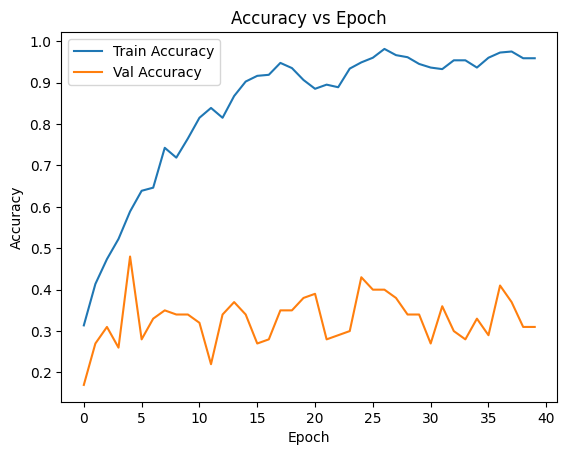

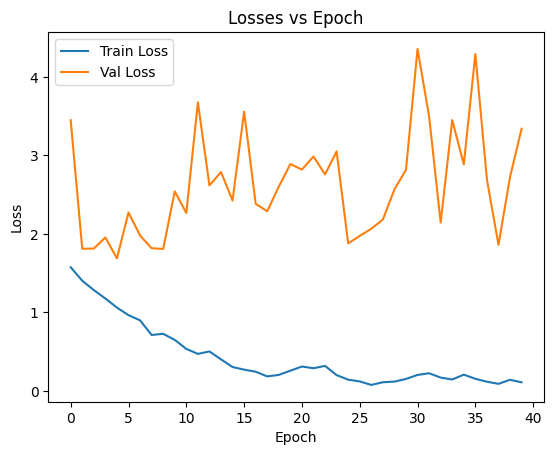

In [ ]:
# HINT: note that your training time should not take more than 2 hours.
# TODO:
# Pick your hyper parameters
from torchvision.models import densenet121, DenseNet121_Weights

max_epoch = 40
train_batch = 32
val_batch = 32
test_batch = 32
learning_rate = 1e-3
weight_decay = 5e-04
NUM_CLASSES = get_num_of_classes('dataFolder/folder')
# Get dataset loaders
data_foldername = 'dataFolder/folder'
train_loader, test_loader, val_loader = get_loaders(data_foldername, train_batch, test_batch, val_batch)

# initialize your network
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")


torch.cuda.empty_cache()

model = DenseNet121(n_classes=NUM_CLASSES)
if use_gpu:
    model.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# start training
history = train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path=f'best_model_inception.pth')

# Plot losses vs epoch
plot_accuracies(history)

# Plot accuracies vs epoch
plot_losses(history)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Loss: 1.2942
Accuracy: 0.4600
Macro Precision: 0.4536
Macro Recall: 0.4579
Macro F1 Score: 0.4455


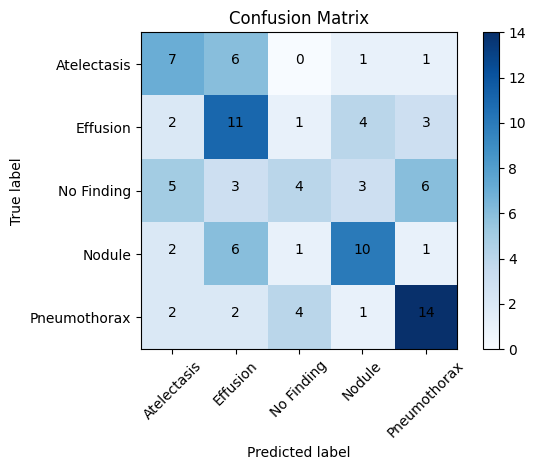

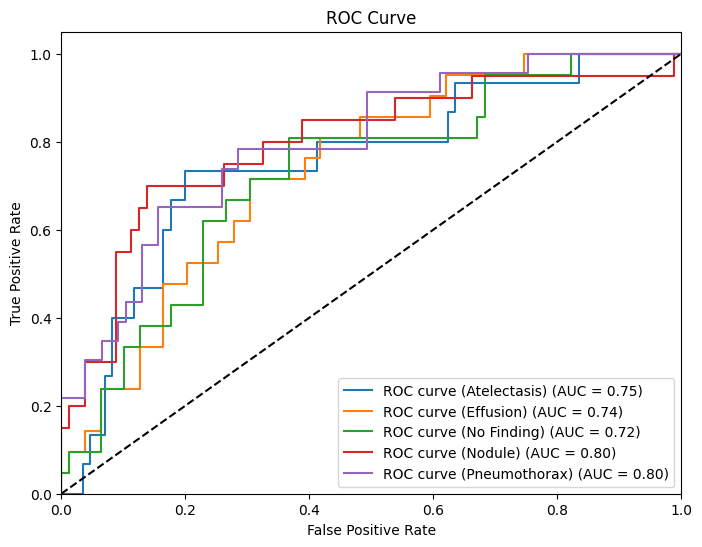

In [ ]:
# Test CNN
# load best model

best_path = os.path.join(os.getcwd(), 'best_model_inception.pth')

model = load_best_model_transfer(best_path, data_foldername)

# evaluate on test set
losses, predictions, targets, probs = test_model(model, test_loader, device)
metrics = calculate_metrics(losses, predictions, targets)

# Print metrics
print("Mean Loss: {:.4f}\nAccuracy: {:.4f}\nMacro Precision: {:.4f}\nMacro Recall: {:.4f}\nMacro F1 Score: {:.4f}".format(
    metrics['mean_loss'], metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']))

# plot confusion matrix
conf_matrix = confusion_matrix(targets, predictions)
plot_confusion_matrix(conf_matrix, class_names)

# plot ROC-AUC curves
plot_roc_auc(targets, probs, class_names)